# STAT 301 Group Assignment
# 1. Title Page
**Type**: Final Group Project <br>
**Group 42 members**: Anthony Leong, Brian Ni, Shivani Aggarwal, Tina Yu <br> 
**TA**: Yian Lin

# 2. Introduction
## Background and Research Motivation

With the growth of peer-to-peer accommodation platforms, Airbnb has become a dominant player in the short-term rental market across major cities worldwide with over 5 million listings worldwide. The pricing of Airbnb listings varies significantly, driven by numerous listing and location-specific characteristics. There are numerous studies examining this relationship for various reasons:
- **Understanding what factors are associated with the variation in Airbnb prices can help both hosts optimize their listings and travelers make more informed booking decisions.**
- Scholars have argued that the existence of Airbnb listings raise the cost of living for local renters as landlords are switching their property to cater short-term rentals, decreasing supply for long-term renters and driving up the rental rates over time (Barron et al., 2019).
- The growth of Airbnb in neighbours that are not traditionally touristic brings economic growth to these areas, while also disrupting the hotel industry (Deboosere et al., 2019).

While many studies have identified factors associated with listing prices, fewer have evaluated whether these features can be used to *predict prices* with reasonable accuracy. In this project, we explore this predictive focus using Airbnb listings across 10 popular European cities.

## Research Questions
We are interesting in answering the following research question in this report through our analysis.
- **Can we predict the price of an Airbnb listing based on its characteristics?**  
   - This question is predictive. We aim to build a model to estimate listing prices from available features, assessing model performance on unseen data.

> The question is answerable using the variables in our dataset, and align with the prediction techniques we’ve learned in class.

# 3. Methods and Results
## A) Data
### Airbnb Prices in European Cities
*(content from Shivani's assignment 2)*

This dataset provides information about Airbnb listings and their prices in 10 popular European cities - Amsterdam, Athens, Barcelona, Berlin, Budapest, Lisbon, London, Paris, Rome, Vienna. The listing prices are attributed to several characteristics such as room types, cleanliness and satisfaction ratings, number of bedrooms, and so on. Each city has two .csv files - for weekdays and weekends each.

The dataset contains 21 variables as described in the table below: 

| Variable | Description | Type |
| -------- | ----------- | ---- |
|`realSum`| The total price of the Airbnb listing| Numeric|
|`room_type`| The type of room being offered (private, shared, etc.)| Categorical|
|`room_shared`|	Whether the room is shared or not| Boolean|
|`room_private`| Whether the room is private or not| Boolean|
|`person_capacity`|	The maximum number of people that can stay in the room| Numeric|
|`host_is_superhost`|Whether the host is a superhost or not | Boolean|
|`multi`|	Whether the host has 2-4 listings | Boolean|
|`biz`|	Whether the host has more than 2 listings |Boolean|
|`cleanliness_rating`|	The cleanliness rating of the listing (0-10) |Numeric|
|`guest_satisfaction_overall`|	The overall guest satisfaction rating of the listing (0-100) | Numeric|
|`bedrooms`|	The number of bedrooms in the listing |Numeric|
|`dist`|	The distance from the city centre |Numeric|
|`metro_dist`|	The distance from the nearest metro station |Numeric|
|`atrr_index`| Attraction index determined by the number of reviews at nearby attractions | Numeric|
|`atrr_index_norm`| Normalized attraction index: scale to 100 | Numeric|
|`rest_index`| Restaurant index determined by the number of reviews at nearby restaurants | Numeric|
|`rest_index_norm`| Normalized restaurant index: scale to 100 | Numeric|
|`lng`|	The longitude of the listing |Numeric|
|`lat`|	The latitude of the listing |Numeric|

### Source of Data
*(content from Shivani's assignment 2)*

This dataset is scraped off of a bigger dataset published in the article ***Determinants of Airbnb prices in European cities:  A spatial econometrics approach*** ([DOI link](https://doi.org/10.1016/j.tourman.2021.104319)) authored by Kristóf Gyódi and Łukasz1 Nawaro and published on January 13, 2021.

The dataset in the article is collected by web-scraping the Airbnb platform to look for accomodations for two people and two nights in 10 major European cities, 4-6 weeks in advance of the travel dates.

### Pre-selection of Variables
*(content from Shivani's assignment 2)*

For the purpose of this assignment, we will use weekdays and weekends data from only 3 cities - Budapest, London, and Rome. This warrants the relevance of 6 .csv files with different number of observations. Below is a list of the observations in each file.
- `budapest_weekdays.csv`: $2,074$
- `budapest_weekends.csv`: $1,948$
- `london_weekdays.csv`: $4,614$
- `london_weekends.csv`: $5,379$
- `rome_weekdays.csv`: $4,492$
- `rome_weekends.csv`: $4,535$

Since the data is scattered across 6 .csv files, we will read in all of the files and combine them into one dataset, `airbnb`, with all the information. The total number of observations in the combined dataset will be $23,042$. We will do so by adding two columns:
- `city` which stores the values of the cities, and
- `weekend` which stores the value of 1 for weekends and 0 for weekdays.


We will also remove some variables we don't see fit when we conduct our analysis. Below is a detailed description of such variables:
- `X` which is the index value for each listing in each dataset (and it therefore has repetitions across different .csv files)
- `room_shared` and `room_private` since the type of room is already captured by the categorical variable `room_type`
- `lat` and `lng` as the location of the listing will be captured by the new variable `city` and we do not plan to use spatial featuring, maps or clusters for our analysis for which these variables would be useful

The following variables are also somewhat redundant but they still hold theoretical value:
- `attr_index` and `rest_index` as normalized data for attraction and restaurant indices are captured by `attr_index_norm` and `rest_index_norm`. However, later on, we will test to see whether normalized variables are perfectly scaled version of raw variables by checking their VIF scores before implementing model selection methods.

### Reading the data
We read in the data from our public GitHub repository which stores the required .csv files. 

We will add the columns `city` and `weekend` and remove the variable `X` when combining all the .csv files into one dataset named `airbnb`.

In [2]:
# required libraries
library(tidyverse)
library(repr)
library(broom)
library(ggplot2)
library(glmnet)
library(car)
library(MASS)
library(caret)
library(dplyr)
# install.packages("corrplot")
library(corrplot)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.2     ✔ tibble    3.2.1
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.0.4     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Loading required package: Matrix


Attaching package: 'Matrix'


The following objects are masked from 'package:tidyr':

    expand, pack, unpack


Loaded glmnet 4.1-8

Loading required package: carData


Attaching package: 'car'


The following object is masked from 'package:dplyr':

    recode


The following object is masked from 'package:purrr':

    some



Attaching package: 'MASS'


The following object is masked from 'package:dplyr':

    select


Loading required

In [3]:
# code taken from Shivani's assignment 2
# loading data from public GitHub repo
bud_wd_url <- "https://raw.githubusercontent.com/shivani-aggarw/stat301/refs/heads/main/data/budapest_weekdays.csv"
bud_we_url <- "https://raw.githubusercontent.com/shivani-aggarw/stat301/refs/heads/main/data/budapest_weekends.csv"
lon_wd_url <- "https://raw.githubusercontent.com/shivani-aggarw/stat301/refs/heads/main/data/london_weekdays.csv"
lon_we_url <- "https://raw.githubusercontent.com/shivani-aggarw/stat301/refs/heads/main/data/london_weekends.csv"
rom_wd_url <- "https://raw.githubusercontent.com/shivani-aggarw/stat301/refs/heads/main/data/rome_weekdays.csv"
rom_we_url <- "https://raw.githubusercontent.com/shivani-aggarw/stat301/refs/heads/main/data/rome_weekends.csv"

In [4]:
# code taken from Shivani's assignment 2
# reading in the .csv files and wrangling them
bud_wd <- read.csv(bud_wd_url)
bud_wd <- bud_wd  %>% 
    mutate(city = "Budapest",
          weekend = 0)  

bud_we <- read.csv(bud_we_url)
bud_we <- bud_we  %>% 
    mutate(city = "Budapest",
          weekend = 1)    

lon_wd <- read.csv(lon_wd_url)
lon_wd <- lon_wd  %>% 
    mutate(city = "London",
          weekend = 0) 

lon_we <- read.csv(lon_we_url)
lon_we <- lon_we  %>% 
    mutate(city = "London",
          weekend = 1)  

rom_wd <- read.csv(rom_wd_url)
rom_wd <- rom_wd  %>% 
    mutate(city = "Rome",
          weekend = 0)

rom_we <- read.csv(rom_we_url)
rom_we <- rom_we  %>% 
    mutate(city = "Rome",
          weekend = 1)  

In [5]:
# code taken from Shivani's assignment 2
# combining all datasets into one
airbnb <- rbind(bud_wd, bud_we, lon_wd, lon_we, rom_wd, rom_we)  %>% 
    dplyr::select(-X)

# visualizing the dataset
head(airbnb, 3)
tail(airbnb, 3)

,realSum,room_type,room_shared,room_private,person_capacity,host_is_superhost,multi,biz,cleanliness_rating,guest_satisfaction_overall,⋯,dist,metro_dist,attr_index,attr_index_norm,rest_index,rest_index_norm,lng,lat,city,weekend
,<dbl>,<chr>,<chr>,<chr>,<dbl>,<chr>,<int>,<int>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>
1,238.9905,Entire home/apt,False,False,6,True,0,1,10,99,⋯,0.3593550,0.3526430,404.4047,24.116552,893.4773,67.65685,19.05074,47.50076,Budapest,0
2,300.7943,Entire home/apt,False,False,6,False,0,1,9,98,⋯,0.9294272,0.2002355,1676.8760,100.000000,452.5397,34.26770,19.04493,47.50405,Budapest,0
3,162.3819,Entire home/apt,False,False,4,True,0,0,10,98,⋯,2.4508403,0.2794518,163.5885,9.755551,191.9923,14.53825,19.02170,47.49882,Budapest,0


,realSum,room_type,room_shared,room_private,person_capacity,host_is_superhost,multi,biz,cleanliness_rating,guest_satisfaction_overall,⋯,dist,metro_dist,attr_index,attr_index_norm,rest_index,rest_index_norm,lng,lat,city,weekend
,<dbl>,<chr>,<chr>,<chr>,<dbl>,<chr>,<int>,<int>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>
23040,878.5916,Entire home/apt,False,False,6,True,1,0,10,99,⋯,2.759242,1.1953387,759.3691,16.82416,1783.2686,38.85310,12.46900,41.90100,Rome,1
23041,447.2448,Entire home/apt,False,False,4,True,1,0,10,98,⋯,1.641598,0.8588370,1125.8572,24.94387,1687.8958,36.77516,12.48342,41.89634,Rome,1
23042,265.8219,Entire home/apt,False,False,6,False,0,1,10,96,⋯,4.411877,0.3524935,167.7019,3.71551,467.3403,10.18221,12.53000,41.86700,Rome,1


## B) Exploratory Data Analysis (EDA)
### Wrangling the data
We will start by cleaning the code by removing the pre-selected variables which we identified as redundant and useless in our analysis. These are `room_shared`, `room_private`, `lat`, and `lng`.
We will also add a column named `ID` to identify each row with a unique number to split the dataset.

In [17]:
# cleaning dataset
airbnb_clean <- airbnb %>%
    dplyr::select(-room_shared, -room_private, -lat, -lng) %>%
    mutate(ID = row_number())

head(airbnb_clean, 3)

,realSum,room_type,person_capacity,host_is_superhost,multi,biz,cleanliness_rating,guest_satisfaction_overall,bedrooms,dist,metro_dist,attr_index,attr_index_norm,rest_index,rest_index_norm,city,weekend,ID
,<dbl>,<chr>,<dbl>,<chr>,<int>,<int>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<int>
1,238.9905,Entire home/apt,6,True,0,1,10,99,1,0.3593550,0.3526430,404.4047,24.116552,893.4773,67.65685,Budapest,0,1
2,300.7943,Entire home/apt,6,False,0,1,9,98,2,0.9294272,0.2002355,1676.8760,100.000000,452.5397,34.26770,Budapest,0,2
3,162.3819,Entire home/apt,4,True,0,0,10,98,1,2.4508403,0.2794518,163.5885,9.755551,191.9923,14.53825,Budapest,0,3


In [23]:
# counting missing values
sum(is.na(airbnb_clean))

[1] 0

### Splitting dataset
<font color = "red"> add reason </font> Now we will slice the dataset into a 60-20-20 splits, named `airbnb_training`, `airbnb_validation`, and `airbnb_testing` respectively. We will also remove the variable `ID` from these subsets as it is not relevant for our regression.

In [18]:
# splitting data into three sets - one for training, one for validation, one for testing
set.seed(9999)

airbnb_training <- slice_sample(airbnb_clean, prop = 0.6)   # 60% of the data
airbnb_remaining <- anti_join(airbnb_clean, airbnb_training, by = "ID")
airbnb_validation <- slice_sample(airbnb_remaining, prop = 0.5)   # 20% of the data
airbnb_testing <- anti_join(airbnb_remaining, airbnb_validation, by = "ID")   # 20% of the data

# dropping ID
airbnb_training <- dplyr::select(airbnb_training, -ID)
airbnb_validation <- dplyr::select(airbnb_validation, -ID)
airbnb_testing <- dplyr::select(airbnb_testing, -ID)

head(airbnb_training, 3)

,realSum,room_type,person_capacity,host_is_superhost,multi,biz,cleanliness_rating,guest_satisfaction_overall,bedrooms,dist,metro_dist,attr_index,attr_index_norm,rest_index,rest_index_norm,city,weekend
,<dbl>,<chr>,<dbl>,<chr>,<int>,<int>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>
1,115.9482,Private room,2,False,0,0,9,96,1,5.709598,1.181127,197.9007,13.75685,440.1913,7.878657,London,1
2,161.5505,Entire home/apt,4,False,0,0,10,95,2,5.550061,0.864905,138.0221,3.05794,381.7032,8.316387,Rome,1
3,262.7061,Private room,4,False,0,0,9,85,1,6.458999,1.407879,198.1813,13.77636,381.8880,6.835130,London,1


### Visualization of Data
To visualize the relationship between Airbnb listing prices and other explanatory variables, we used two plots:
- **Contour Plot** shows the relationships between Airbnb listing price and distance of the listing from the city centre and the nearest metro station (`dist` and `metro_dist`), faceted by the type of room (`room_type`). This plot will help us visualize the popularity of different room types at different prices and distances from city centres and metros. The lighter the color, the more common the room type is at that price and distance point.
- **Violin Boxplot** to visualize the relationship of price with overall satisfaction levels (`guest_satisfaction_overall`), faceted by city (`city`). This plot will help us visualize the distribution of prices across different satisfaction levels, and how this relationship differs across cities.

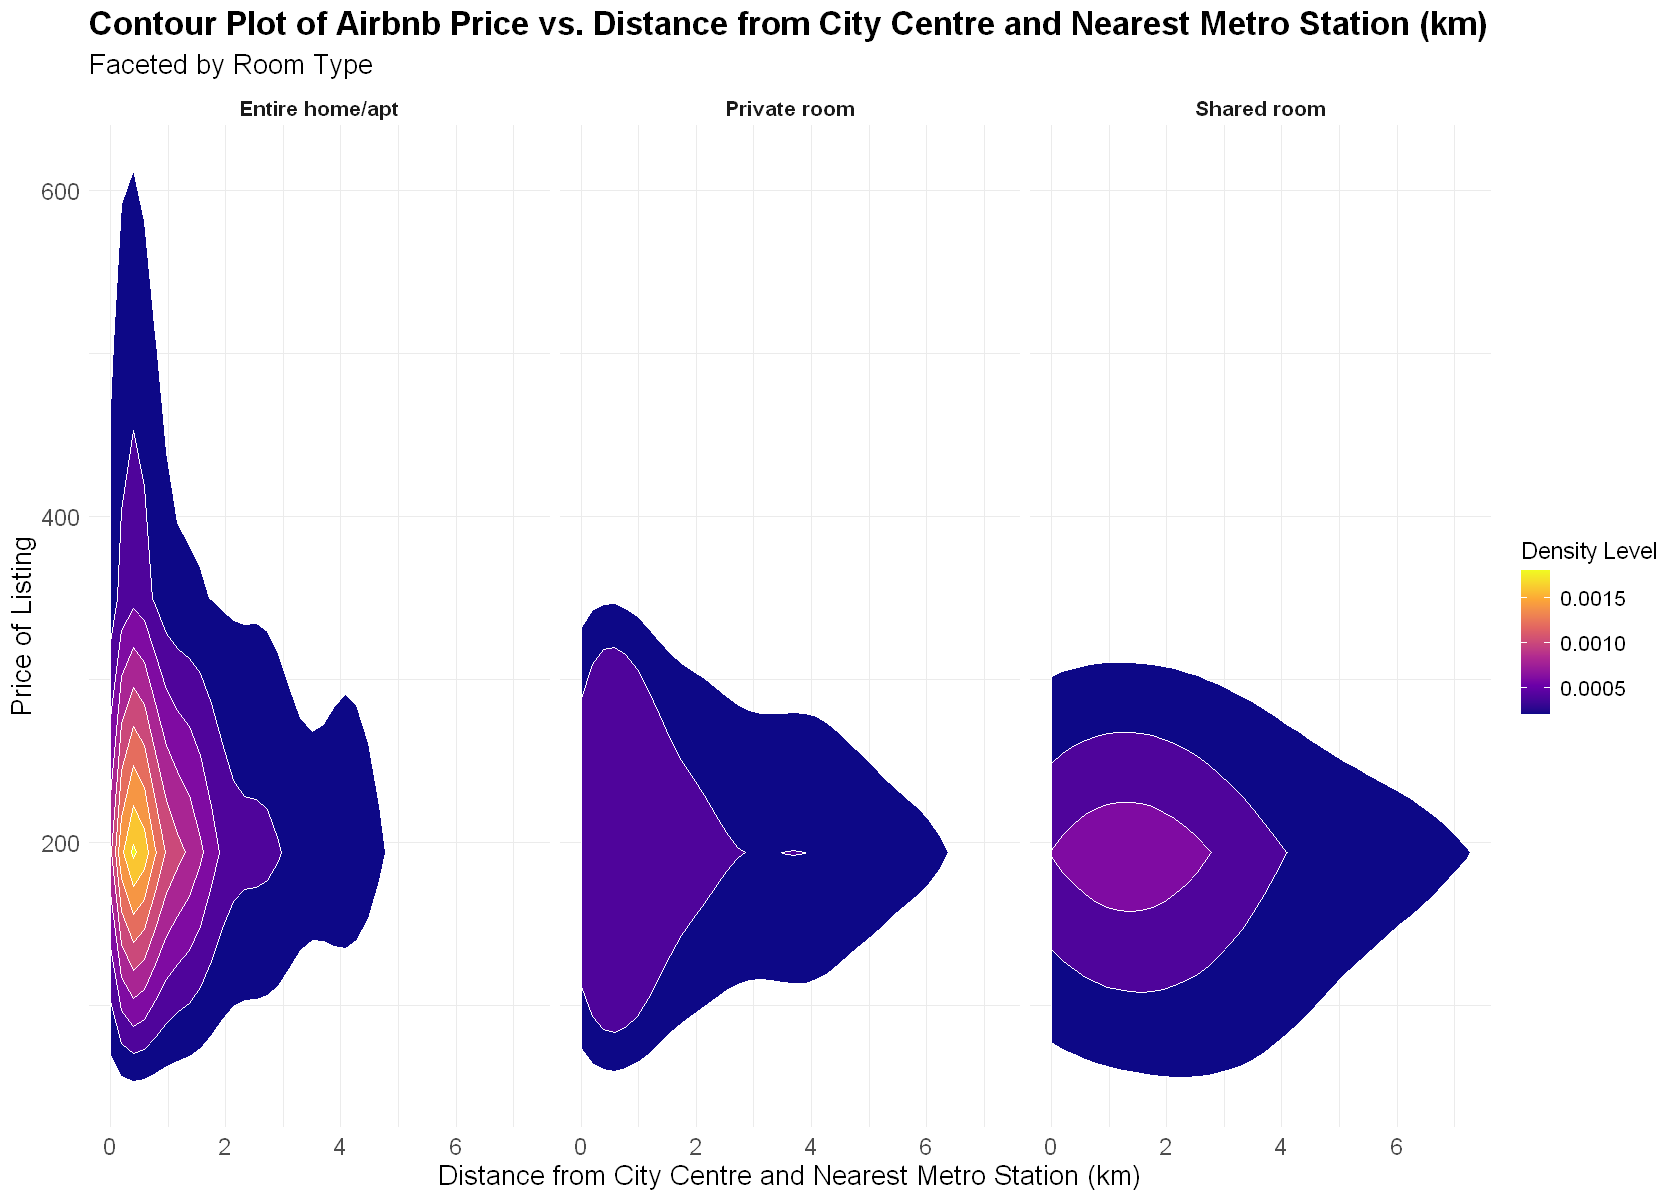

In [19]:
# contour plot of price against distance from city centre and nearest metro station
options(repr.plot.width = 14, repr.plot.height = 10)

# code taken from Brian's assignment 2
# combining dist and metro_dist into one variable
airbnb_train_distance <- airbnb_training %>%
    dplyr::select(realSum, dist, metro_dist, room_type) %>%
    mutate(realSum_shifted = if_else(realSum <= 0, 1, realSum)) %>%
    pivot_longer(
        cols = c(dist, metro_dist),
        names_to = "DistanceType",
        values_to = "Distance")

# plotting variables
ggplot(airbnb_train_distance, aes(x = Distance, y = realSum_shifted)) +
    stat_density_2d(aes(fill = after_stat(level)), geom = "polygon", color = "white", contour = TRUE) +
    facet_wrap(~ room_type) + 
    scale_fill_viridis_c(option = "C", name = "Density Level") +
    labs(
        title = "Contour Plot of Airbnb Price vs. Distance from City Centre and Nearest Metro Station (km)",
        subtitle = "Faceted by Room Type",
        x = "Distance from City Centre and Nearest Metro Station (km)",
        y = "Price of Listing"
  ) +
    theme_minimal(base_size = 12) +
    theme(
        text = element_text(size = 16), 
        plot.title = element_text(size = 20, face = "bold"),  
        axis.title = element_text(size = 16),  
        axis.text = element_text(size = 14),  
        legend.title = element_text(size = 14),
        strip.text = element_text(face = "bold")
  )

#### Interpretation of contour plot

The contour plot reveals a tendency for listings closer to the city centre or a metro station to be more expensive, and that entire homes and private rooms are generally more expensive than shared rooms. However, most listings, regardless of distance or purpose, tend to fall within a similar price range. We also observe that entire homes or apartments listed on Airbnb are generally located closer to the city centre or metro stations and are priced higher on average.

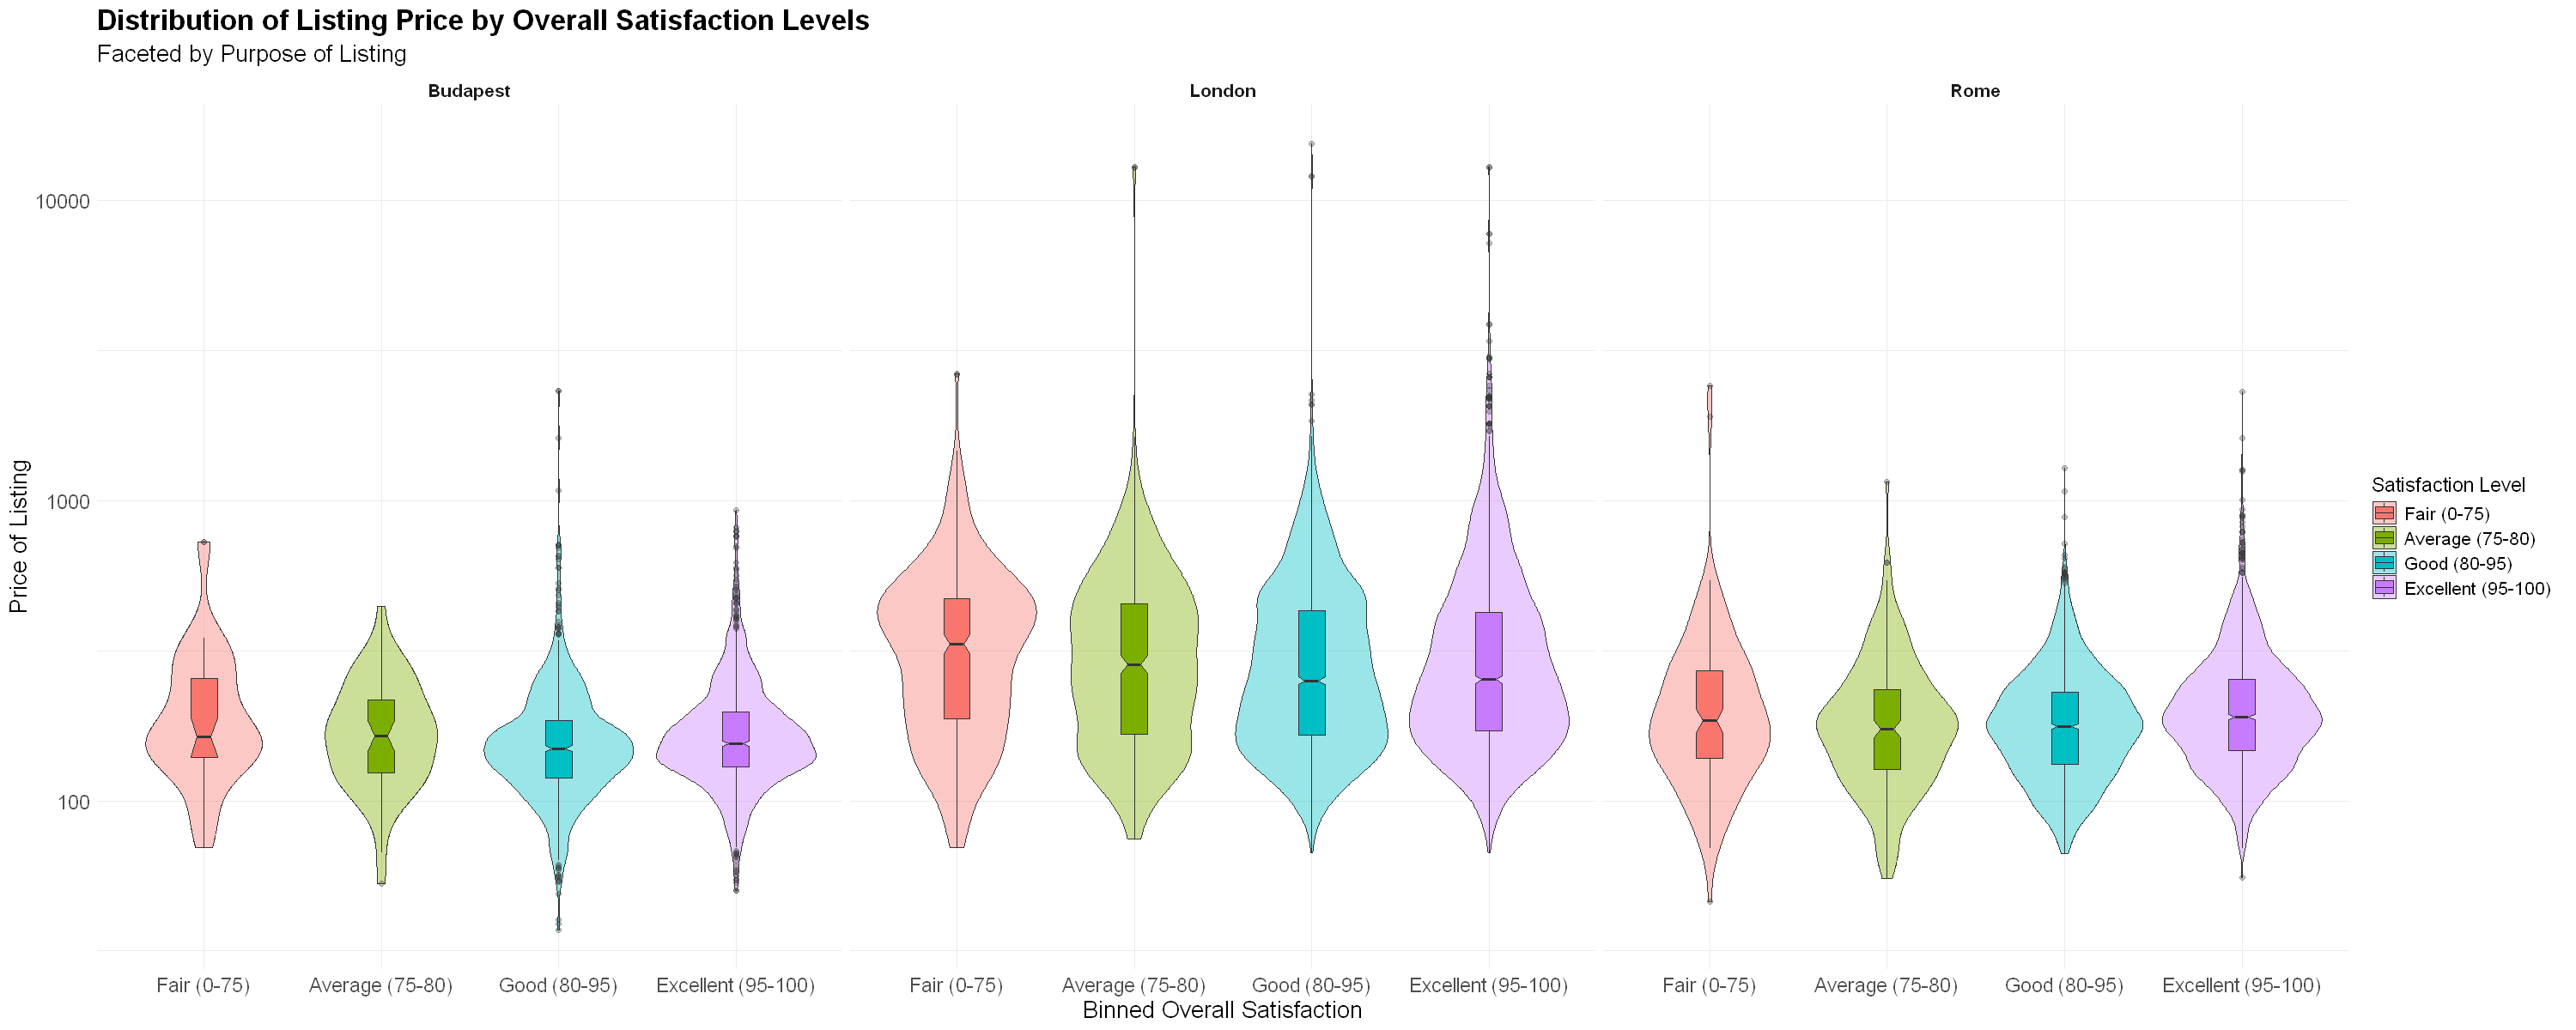

In [24]:
# code taken from Brian's assignment 2
options(repr.plot.width=25, repr.plot.height=10)

# Create bins for guest_satisfaction_overall
airbnb_train_binned <- airbnb_training %>%
  mutate(
    satis_bin = cut(guest_satisfaction_overall,
      breaks = c(0, 75, 80, 95, Inf),
      labels = c("Fair (0-75)","Average (75-80)","Good (80-95)", "Excellent (95-100)")
    )
  )

# Combine violin plot + boxplot, facet by city, log-scale on y-axis
ggplot(airbnb_train_binned, aes(x = satis_bin, y = realSum, fill = satis_bin)) +
    geom_violin(alpha = 0.4) +
    geom_boxplot(width = 0.15, outlier.alpha = 0.3, notch = TRUE) +
    facet_wrap(~ city) + 
    scale_y_log10() +
    labs(
        title = "Distribution of Listing Price by Overall Satisfaction Levels",
        subtitle = "Faceted by Purpose of Listing",
        x = "Binned Overall Satisfaction",
        y = "Price of Listing",
        fill = "Satisfaction Level"
    ) +
    theme_minimal() +
    theme(
        text = element_text(size = 16), 
        plot.title = element_text(size = 20, face = "bold"),  
        axis.title = element_text(size = 16),  
        axis.text = element_text(size = 14),  
        legend.title = element_text(size = 14),
        strip.text = element_text(face = "bold")
    )

#### Interpretation of violin boxplot
The chart suggests that higher overall ratings for Airbnb properties do not necessarily correspond to higher or lower listing prices. It is interesting to note that listings with lower overall ratings, however, usually have prices in the higher range, suggesting that higher price for a bad experience at an Airbnb could be a factor in the lower rating. We also observe that listings are more expensive in London, followed by Rome and Budapest. 

### Summary Tables
Now that we have explored the relationships within the data, we are also interested in understanding its structure and quality. 

We will begin by checking for any missing values to ensure data completeness. Then, we will examine the range of listing prices grouped by city to understand pricing variation across locations.

In [21]:
# counting missing values
sum(is.na(airbnb_training))

[1] 0

In [22]:
# summarizing the range of prices
airbnb_training %>%
  group_by(city) %>%
  summarise(
    min_price = min(realSum, na.rm = TRUE),
    max_price = max(realSum, na.rm = TRUE),
    mean_price = mean(realSum, na.rm = TRUE)
  ) %>%
  arrange(desc(mean_price))

city,min_price,max_price,mean_price
<chr>,<dbl>,<dbl>,<dbl>
London,67.02886,15499.894,366.9309
Rome,46.05709,2418.348,206.2775
Budapest,37.12929,2330.216,176.2546


From the range of prices, we can observe substantial variation in pricing across the three cities. This suggests that city-specific factors significantly influence Airbnb prices. For our analysis, it highlights the importance of incorporating `city` as a key variable in our model. 

## C) Methods Plan
To address our research questions,
> **How is price associated with the different characteristics of an Airbnb listing and can we predict them?**

we propose to use **Multi-variable Least Squares Regression** framework focussed on prediction. 

This will help us quantify the relationship between our quantitative response variable `realSum` and the explanatory variables, while creating a model with strong out-of-sample predictability. To improve model interpretability and reduce potential overfitting, we will compare multiple model selection methods and choose the model that will give us the ***lowest Root Mean Squared Error (RMSE)***. RMSE is well-suited to test prediction accuracy as it directly measures the average magnitude of prediction errors in the same units as the response variable. The model selection methods we will test are:
- Backward stepwise selection using AIC
- LASSO (L1 regularization), and
- Ridge (L1 regularization)

We choose backward stepwise selection method over forward selection as we believe that most of the variables in our dataset are relevant predictors and starting with a full model will help us retain these important predictors that might otherwise be missed in forward selection process.

Additionally, we will **split the data into three subsets** and use 60% of the rows to train the model selection methods, 20% of the rows to fit the reduced model and validate the resulting RMSE, and finally the remaining 20% to fit our selected model to test its predictive power. This will help us avoid the post-inference problem we could potentially run into while selecting variables and fitting the model on the same data. 

We will also test the selected variables from the *best* model for multicollinearity using the VIF test to remove any remaining multicollinear variables and avoid inflated standard errors caused by linear dependence between predictors.

### Assumptions in the Model
In order to use the ordinary least square regression, we first have to make the following assumptions:

- **Linearity**: The relationship between the response and explanatory variable is linear.
- **Independence**: The residual errors are independent of each other since we have a random sample. 
- **Homoscedasticity**: The variance of residuals is constant across all levels of the explanatory variables.
- **Normality**: The conditional distribution of error is normal. This also reinstates the linearity assumption that the conditional expectation of the response is linear.
- **Non-multicollinearity**: There is no perfect correlation between two or more explanatory variables. We will also test for this assumption through a VIF test.

### Testing for Scaled versions of Existing Variables
We identified earlier that the normalized variables, `attr_index_norm` and `rest_index_norm`, may be perfectly scaled versions of their raw counterparts, `attr_index` and `rest_index`. If that is the case, it would violate our non-multicollinearity assumption, which requires that no explanatory variable be a perfect linear combination of others. Including both versions in the model would lead to redundancy and inflated standard errors. 

We will test for multicollinearity using the Variance Inflation Factor (VIF) scores to determine whether to keep the raw or normalized variables in our final regression model.

In [9]:
# checking multicollinearity
options(repr.matrix.max.rows = 18)

# vif scores with all variables
pre_vif <- vif(lm(realSum ~., data = airbnb_training))
pre_vif

,GVIF,Df,GVIF^(1/(2*Df))
room_type,1.688956,2,1.139999
person_capacity,2.153756,1,1.467568
host_is_superhost,1.155365,1,1.074879
multi,1.433745,1,1.197391
biz,1.592306,1,1.261866
cleanliness_rating,2.256942,1,1.502312
guest_satisfaction_overall,2.336237,1,1.528475
bedrooms,1.552735,1,1.246088
dist,4.764003,1,2.182660
metro_dist,1.923162,1,1.386781


We will focus on the **GVIF^(1/(2*Df))** column to decide the variable selection process as our dataset contains multiple categorical variables. We can see that `attr_index` has a higher score than `attr_index_norm` and `rest_index` has a higher score than `rest_index_norm`. Therefore, we will remove the raw variables `attr_index` and `rest_index`.  

In [10]:
# removing raw variables as they have higher VIF scores than normalized variables
airbnb_training <- dplyr::select(airbnb_training, -c(attr_index, rest_index))
airbnb_validation <- dplyr::select(airbnb_validation, -c(attr_index, rest_index))
airbnb_testing <- dplyr::select(airbnb_testing, -c(attr_index, rest_index))

# vif scores without raw variables
post_vif <- vif(lm(realSum ~., data = airbnb_training))
post_vif

,GVIF,Df,GVIF^(1/(2*Df))
room_type,1.682548,2,1.138916
person_capacity,2.153721,1,1.467556
host_is_superhost,1.154421,1,1.074440
multi,1.433691,1,1.197368
biz,1.589253,1,1.260656
cleanliness_rating,2.256536,1,1.502177
guest_satisfaction_overall,2.335724,1,1.528307
bedrooms,1.552669,1,1.246061
dist,4.610271,1,2.147154
metro_dist,1.888696,1,1.374298


### Training Model Selection Methods
We will use `airbnb_training` to train our model selection methods. 

For the backward stepwise selection method, we define the null model - which assumes that the best predictor of `realSum` is its average - and the full model - which assumes that it's best predicted by all the variables. The method will start with the full model and iteratively remove variables based on their contribution to the model’s performance measured by AIC. 

To prepare for regularization techniques, on the other hand, we convert the training data into a matrix form so it can be properly utilized by the techniques.

In [11]:
# code taken from Anthony's assignment 2
# full and null models, and training matrix
null_model <- lm(realSum ~ 1, data = airbnb_training)
full_model <- lm(realSum ~ ., data = airbnb_training)
training_matrix <- model.matrix(object = realSum ~ ., data = airbnb_training)[, -1]

In [12]:
# code taken from Anthony's assignment 2
# stepwise training - credit to Anthony
n <- nrow(airbnb_training)
stepwise_model <- stepAIC(full_model,
                          direction = "backward",
                          scope = list(lower = null_model, upper = full_model),
                          k = log(n), trace = 0)
summary(stepwise_model)


Call:
lm(formula = realSum ~ room_type + person_capacity + bedrooms + 
    metro_dist + attr_index_norm + rest_index_norm + city, data = airbnb_training)

Residuals:
    Min      1Q  Median      3Q     Max 
 -792.5   -87.0   -21.5    52.3 14381.6 

Coefficients:
                       Estimate Std. Error t value Pr(>|t|)    
(Intercept)            -53.1468    15.0138  -3.540 0.000402 ***
room_typePrivate room -126.1750     7.5484 -16.715  < 2e-16 ***
room_typeShared room  -171.8360    52.5426  -3.270 0.001077 ** 
person_capacity         18.1128     3.2296   5.608 2.08e-08 ***
bedrooms               104.9495     6.0998  17.205  < 2e-16 ***
metro_dist             -12.0428     3.1909  -3.774 0.000161 ***
attr_index_norm          9.1613     0.4444  20.617  < 2e-16 ***
rest_index_norm         -1.3377     0.3143  -4.256 2.10e-05 ***
cityLondon             160.7517    13.4252  11.974  < 2e-16 ***
cityRome                64.9518     8.9351   7.269 3.81e-13 ***
---
Signif. codes:  0 '***' 0.00

17 x 1 sparse Matrix of class "dgCMatrix"
                                     s1
(Intercept)                -132.0242246
room_typePrivate room      -122.7676012
room_typeShared room       -154.9426967
person_capacity              18.4810079
host_is_superhostTrue        -7.4699179
multi                         .        
biz                           .        
cleanliness_rating            0.9649431
guest_satisfaction_overall    0.7715510
bedrooms                    103.2857589
dist                          .        
metro_dist                  -11.4493809
attr_index_norm               9.1438159
rest_index_norm              -1.3010340
cityLondon                  155.3431521
cityRome                     58.7946663
weekend                       7.1001938

[1] "The lambda related to the minimum MSE in the LASSO model is 0.8548"

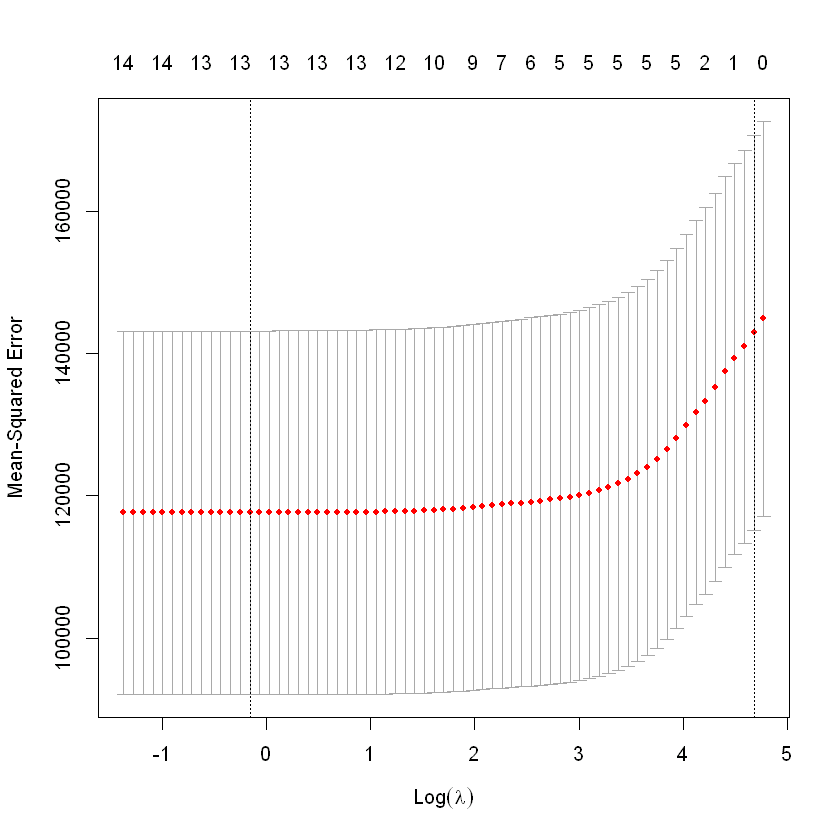

In [13]:
# LASSO training
lasso_model <- cv.glmnet(x = training_matrix, y = airbnb_training$realSum, alpha = 1)
coef(lasso_model, s = "lambda.min")
plot(lasso_model)
sprintf("The lambda related to the minimum MSE in the LASSO model is %.4f", lasso_model$lambda.min)

17 x 1 sparse Matrix of class "dgCMatrix"
                                     s1
(Intercept)                -136.3404254
room_typePrivate room      -118.2070324
room_typeShared room       -163.8599904
person_capacity              19.9317661
host_is_superhostTrue       -10.3792555
multi                        -1.7986375
biz                          -0.2052225
cleanliness_rating            1.9381975
guest_satisfaction_overall    0.7792359
bedrooms                    100.5885161
dist                          0.2474648
metro_dist                  -12.5034415
attr_index_norm               9.0320341
rest_index_norm              -1.3579503
cityLondon                  147.6247581
cityRome                     53.4419201
weekend                       8.8503011

[1] "The lambda related to the minimum MSE in the Ridge model is 11.8374"

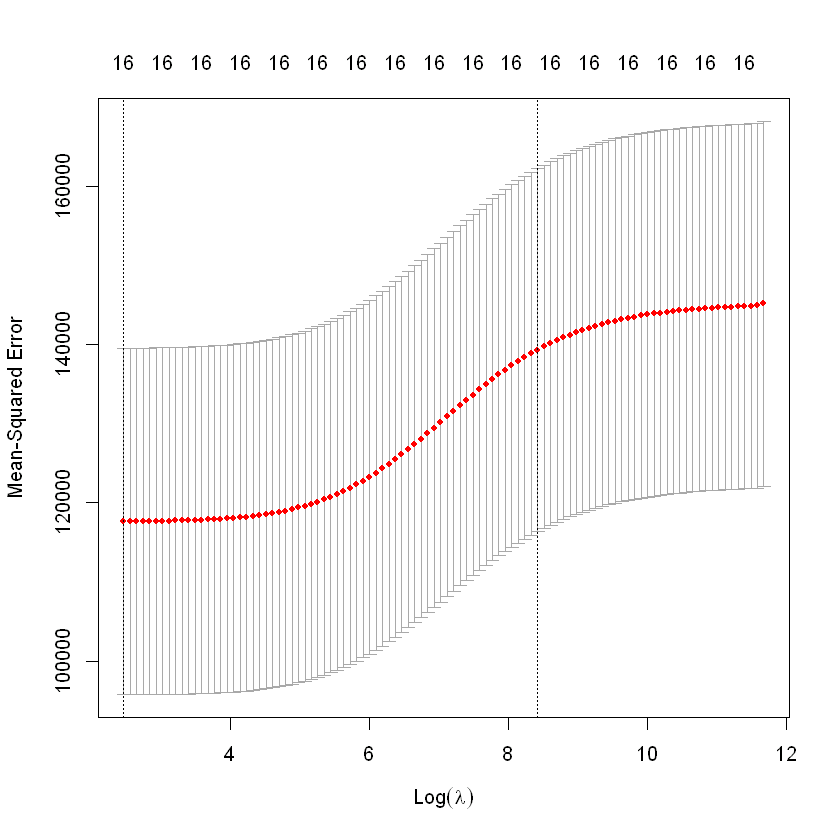

In [14]:
# ridge training
ridge_model <- cv.glmnet(x = training_matrix, y = airbnb_training$realSum, alpha = 0)
coef(ridge_model, s = "lambda.min")
plot(ridge_model)
sprintf("The lambda related to the minimum MSE in the Ridge model is %.4f", ridge_model$lambda.min)

### Validating Model Selection Methods
We will use `airbnb_validation` to test the trained models and choose the best one which has the lowest RMSE.

In [15]:
# validation
validation_matrix <- model.matrix(object = realSum ~ ., data = airbnb_validation)[, -1]
stepwise_preds <- predict(stepwise_model, newdata = airbnb_validation)
lasso_preds <- predict(lasso_model, newx = validation_matrix, s = "lambda.min")
ridge_preds <- predict(ridge_model, newx = validation_matrix, s = "lambda.min")

validation_rmse <- tibble(
    Model = c("Multiple Linear Regression with Stepwise Selection", "LASSO Regression with Minimum MSE", "Ridge Regression with Minimum MSE"),
    RMSE = c(RMSE(stepwise_preds, airbnb_validation$realSum),
             RMSE(lasso_preds, airbnb_validation$realSum),
             RMSE(ridge_preds, airbnb_validation$realSum))
)

validation_rmse

Model,RMSE
<chr>,<dbl>
Multiple Linear Regression with Stepwise Selection,197.2752
LASSO Regression with Minimum MSE,197.1093
Ridge Regression with Minimum MSE,196.9571


### Model Selection
After evaluating the performance of three regression models on the validation set using RMSE, we find that while all models performed similarly, Ridge regression achieved the lowest RMSE (196.96), followed closely by LASSO (197.11) and Stepwise Linear Regression (197.28). This suggests that Ridge regularization slightly improved predictive accuracy.

Since Ridge regression utilizes all variables in the dataset and assigns coefficients to predictors such that multicollinearity is minimized, we won't need to test the VIF scores.

### Fitting the Ridge Model on Testing Data
Now that we've selected the Ridge model, we will fit it on testing data and evaluate its performance.

In [16]:
# preparing testing data in matrix format
test_matrix <- model.matrix(realSum ~ ., data = airbnb_testing)[, -1]

# fitting ridge model on testing data
ridge_test_preds <- predict(ridge_model, newx = test_matrix, s = "lambda.min")

In [17]:
# evaluating performance of the ridge model
ridge_test_rmse <- RMSE(ridge_test_preds, airbnb_testing$realSum)
ridge_test_rmse

[1] 198.2848

In [18]:
# visualizing ridge coefficients again
coef(ridge_model, s = "lambda.min")

17 x 1 sparse Matrix of class "dgCMatrix"
                                     s1
(Intercept)                -136.3404254
room_typePrivate room      -118.2070324
room_typeShared room       -163.8599904
person_capacity              19.9317661
host_is_superhostTrue       -10.3792555
multi                        -1.7986375
biz                          -0.2052225
cleanliness_rating            1.9381975
guest_satisfaction_overall    0.7792359
bedrooms                    100.5885161
dist                          0.2474648
metro_dist                  -12.5034415
attr_index_norm               9.0320341
rest_index_norm              -1.3579503
cityLondon                  147.6247581
cityRome                     53.4419201
weekend                       8.8503011

# 4. Discussion
<font color = "red"> **(delete before submitting)** </font>
In this section, you’ll interpret and reflect on the results you obtained in the previous section with respect to the main question/goal of your project.

Summarize what you found and the implications/impact of your findings
If relevant, discuss whether your results were what you expected to find
Discuss how your model could be improved
Discuss future questions/research this study could lead to

# 5. References
Barron, K., Kung, E., & Proserpio, D. (2019). *When Airbnb Listings in a City Increase, So Do Rent Prices.* Harvard Business Review. https://ci.carmel.ca.us/sites/main/files/file-attachments/harvard_business_article_and_study.pdf

Deboosere, R., Kerrigan, D. J., Wachsmuth, D., & El-Geneidy, A. (2019). *Location, location and professionalization: a multilevel hedonic analysis of Airbnb listing prices and revenue.* Regional Studies, Regional Science, 6(1), 143–156. https://doi.org/10.1080/21681376.2019.1592699

Gyódi, K., & Nawaro Ł. (2021). *Determinants of Airbnb prices in European cities: A spatial econometrics approach*. https://doi.org/10.1016/j.tourman.2021.104319